<a href="https://colab.research.google.com/github/javihm77/CapstoneProjectImperialCollege/blob/main/Sentiment_Analysis_Vader_Bert_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAPSTONE PROJECT
## Sentiment Analysis of "Por Favor No Se Enoje" YouTube Comments


This notebook presents a sentiment analysis of YouTube comments for the Guatemalan radio program "Por Favor No Se Enoje." The program focuses on political discussions in Guatemala and neighboring countries. This project is part of a Machine Learning and Artificial Intelligence capstone project for Imperial College's [Professional Certificate in Machine Learning and Artificial Intelligence](https://execed-online.imperial.ac.uk/professional-certificate-ml-ai).

**Key Features**:

Data Collection:

*   Comments were collected using the YouTube API.
*   The dataset includes comment text, timestamps, and associated video information (title, views, likes, etc.).

**Data Preprocessing**:

*   Text cleaning was performed to remove punctuation, numbers, and extra spaces.
*   Stop words in Spanish were removed using NLTK's stopwords module.

**Topic Modeling (BERTopic**):

*   BERT-based topic modeling was employed to identify recurring themes in the comments.
*   BERTopic with bigram extraction and UMAP visualization was used for topic generation and exploration.
*  The relationship between identified topics and sentiment was examined.

**Sentiment Analysis**:

*   Vader Sentiment (lexicon-based) was used for initial sentiment analysis.
*   A subset of comments were manually labeled for human sentiment.
*   BERT model for sentiment analysis was fine-tuned using the labeled dataset.
*  The fine-tuned BERT model was applied to predict sentiment on a larger set of comments.

**SHAP Test**:

*  SHAP analysis was employed to explain the fine-tuned BERT model's predictions.
*  It provided insights into the most influential words/features impacting sentiment classification.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Imperial College/Capstone Project/raw_youtube_comments.csv")

# Exploratory data analysis *Raw YouTube Comments*

Converting timezones and datetime to date format

In [ ]:
# Convert dates formats and timezone from UTC to Centroamerican time

df['video published_date'] = pd.to_datetime(df['video published_date']).dt.strftime('%Y-%m-%d')
df['video published_date'] = pd.to_datetime(df['video published_date']).dt.tz_localize('UTC').dt.tz_convert('Etc/GMT+6')

# Convert 'updated_at' to Centroamerican timezone
df['updated_at'] = pd.to_datetime(df['updated_at'])
if df['updated_at'].dt.tz is None: # Check if the series is timezone naive
    df['updated_at'] = df['updated_at'].dt.tz_localize('UTC')
df['updated_at'] = df['updated_at'].dt.tz_convert('Etc/GMT+6')

We can see the raw data obtained in [notebook](https://colab.research.google.com/drive/1rG6cgDjQFuL1x0aPtA_h3QX1uAUxPyu6?usp=sharing) to pull comments from YouTube API

In [ ]:
df.tail(5)

,Unnamed: 0,author,updated_at,like_count,text,video_id,public,video title,video published_date,video view_count,video like_count,video dislike_count,video comment_count
827,827,@oswaldoaldana6928,2024-09-03 15:20:43-06:00,0,Mucho bla bla bla del Sr Alcalde pero no concl...,aH0dy9rjBLI,True,EL QUE ES VUELVE,2024-09-02 18:00:00-06:00,2413,143,0,10
828,826,@aguilar4254,2024-09-03 15:51:10-06:00,0,Entonces que va hacer con los buses y túc túc ...,aH0dy9rjBLI,True,EL QUE ES VUELVE,2024-09-02 18:00:00-06:00,2413,143,0,10
829,825,@irmabrenes2412,2024-09-03 15:58:10-06:00,1,"Leasing=arrendamiento, por si se le está olvid...",aH0dy9rjBLI,True,EL QUE ES VUELVE,2024-09-02 18:00:00-06:00,2413,143,0,10
830,824,@cesarmejiaochoa4845,2024-09-03 16:08:31-06:00,0,El famoso leasing,aH0dy9rjBLI,True,EL QUE ES VUELVE,2024-09-02 18:00:00-06:00,2413,143,0,10
831,823,@rodilmartinez9958,2024-09-03 16:32:52-06:00,0,Si puede indicar después de los 36 meses quien...,aH0dy9rjBLI,True,EL QUE ES VUELVE,2024-09-02 18:00:00-06:00,2413,143,0,10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype                    
---  ------                --------------  -----                    
 0   Unnamed: 0            832 non-null    int64                    
 1   author                832 non-null    object                   
 2   updated_at            832 non-null    datetime64[ns, Etc/GMT+6]
 3   like_count            832 non-null    int64                    
 4   text                  832 non-null    object                   
 5   video_id              832 non-null    object                   
 6   public                832 non-null    bool                     
 7   video title           832 non-null    object                   
 8   video published_date  832 non-null    datetime64[ns, Etc/GMT+6]
 9   video view_count      832 non-null    int64                    
 10  video like_count      832 non-null    int64                   

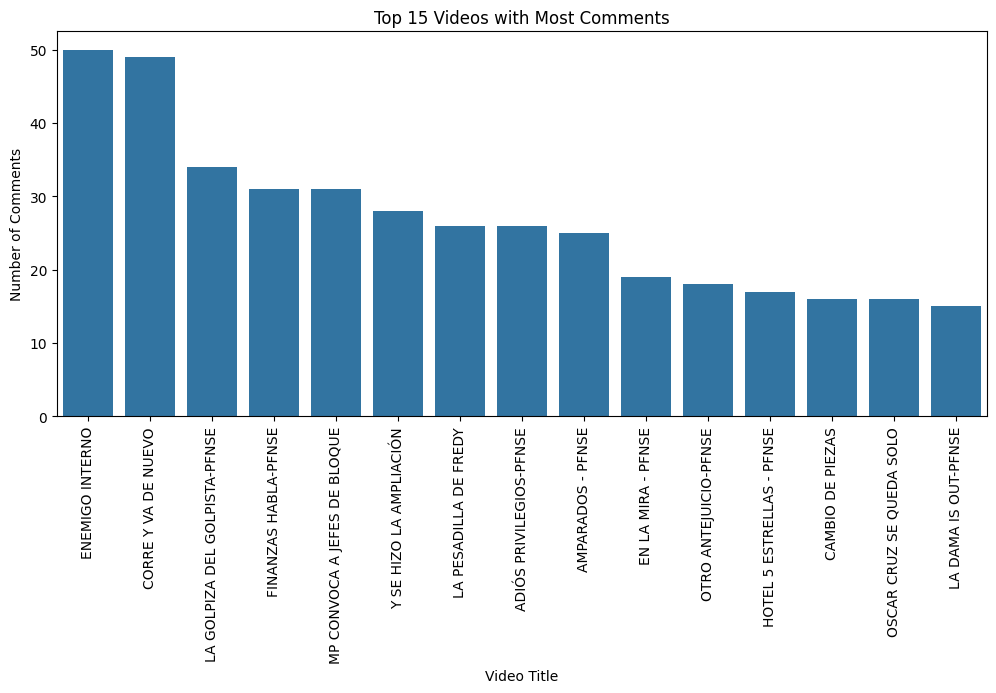

In [ ]:
# @title Top 15 videos with most comments

videos = df["video title"].value_counts()

plt.figure(figsize=(12, 5))
sns.barplot(x=videos.index[:15], y=videos.values[:15])
plt.title("Top 15 Videos with Most Comments")
plt.xlabel("Video Title")
plt.ylabel("Number of Comments")
plt.xticks(rotation=90)
plt.show()

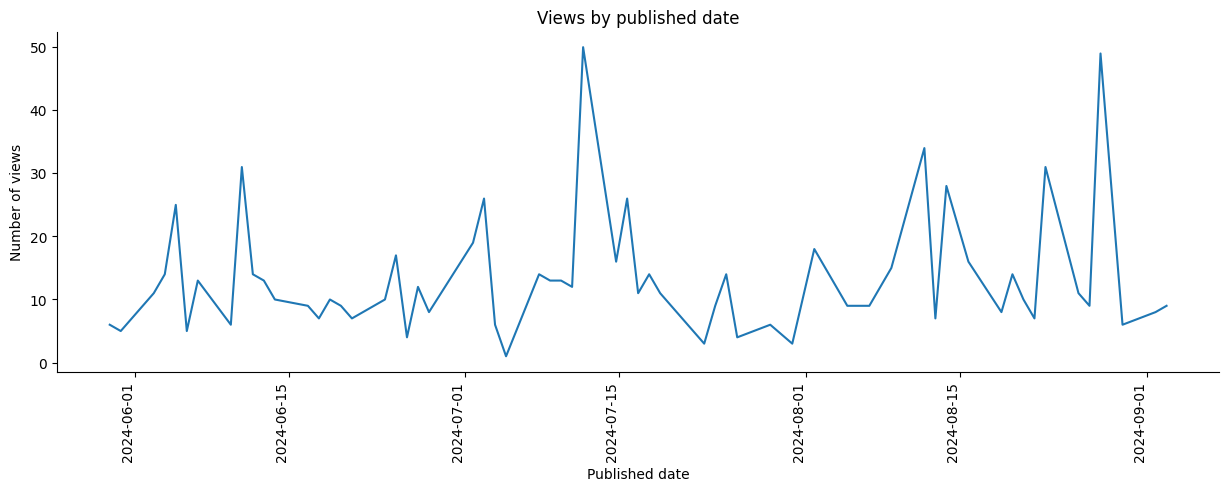

In [ ]:
# @title Views by published date

views = df["video published_date"].value_counts().sort_index()
views.plot(kind='line', figsize=(15, 5), title='Views by published date')
plt.xlabel('Published date')
plt.ylabel('Number of views')
plt.xticks(rotation=90)
plt.gca().spines[['top', 'right']].set_visible(False)

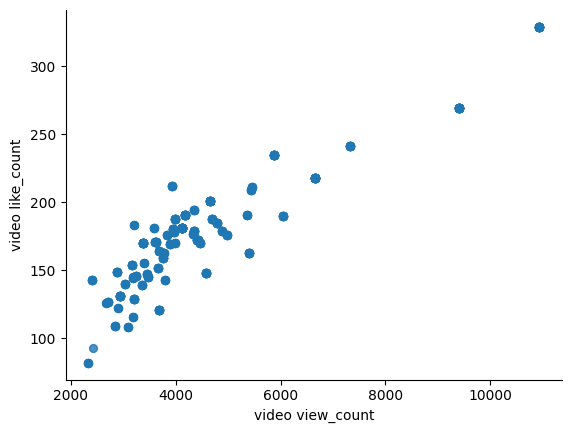

In [ ]:
# @title video view_count vs video like_count

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='video view_count', y='video like_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

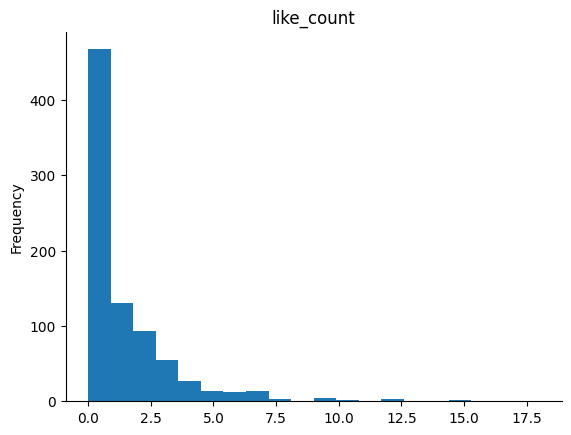

In [ ]:
# @title like_count

from matplotlib import pyplot as plt
df['like_count'].plot(kind='hist', bins=20, title='like_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Processing Comments

In [ ]:
nltk.download('stopwords')

# preprocessing text
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('spanish'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['processed_comment'] = df['text'].apply(preprocess_text)

# df.to_csv('processed_inside_out_2_reviews.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['processed_comment'].head(8)

,processed_comment
0,buena idea😅😅 negocio stickers 😂
1,dineroooo mayoría círculo gobierno turno enriq...
2,excelente exposición tema
3,quique estan delfines
4,grand exponente mejor guate
5,bem duerme refaccionanfo
6,desprecio desprecio paga respecto asistencia d...
7,señor barrientos tuiter😅


### Vader Sentiment

In [ ]:
!pip install vaderSentiment # Fixed typo in the install command

import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

                                   processed_comment vader_sentiment
0                    buena idea😅😅 negocio stickers 😂        positive
1  dineroooo mayoría círculo gobierno turno enriq...         neutral
2                          excelente exposición tema         neutral
3                              quique estan delfines         neutral
4                        grand exponente mejor guate        positive
5                           bem duerme refaccionanfo         neutral
6  desprecio desprecio paga respecto asistencia d...         neutral
7                           señor barrientos tuiter😅        positive


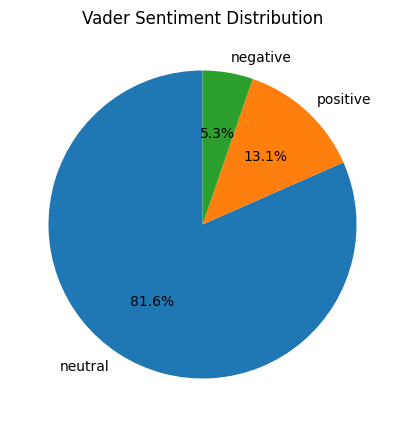

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(score):
    if score >= 0.01:
        return 'positive'
    elif score <= -0.01:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['processed_comment'].apply(lambda x: get_sentiment(analyzer.polarity_scores(x)['compound']))
print(df[["processed_comment","vader_sentiment"]].head(8))

sentiment_counts = df['vader_sentiment'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Vader Sentiment Distribution')
plt.show()

# Saves file adding Vader sentiment classification
df[["text","processed_comment","vader_sentiment"]].to_csv('/content/drive/MyDrive/Imperial College/Capstone Project/processed_vader_youtube_comments.csv', index=True)

## Human labeled comments (from G-Spreadsheets)

Human Labeling done outside notebook in document: [Spreadsheet](https://docs.google.com/spreadsheets/d/10hYdE3OjZ3uBA_HqY1uXnkkPb3cTZp0DZeE7J-BM6BI/edit?usp=sharing)

In [ ]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib --quiet

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Replace with your spreadsheet ID and worksheet name

spreadsheet_id = '10hYdE3OjZ3uBA_HqY1uXnkkPb3cTZp0DZeE7J-BM6BI'
worksheet_name = 'processed_human_youtube_comments'  # Replace 'Sheet1' with the actual sheet name if different

# Open the spreadsheet
sh = gc.open_by_key(spreadsheet_id)

# Select the worksheet
worksheet = sh.worksheet(worksheet_name)

# Get all data as a list of lists
data = worksheet.get_all_values()

# Create a DataFrame using the data and the first row as headers
df = pd.DataFrame(data[1:], columns=data[0])

In [ ]:
df.head(5)

,index,text,processed_comment,vader_sentiment,human_sentiment
0,0,Muy buena idea😅😅 el negocio de los stickers 😂,buena idea😅😅 negocio stickers 😂,positive,positive
1,1,Tanto Dineroooo!!! Por eso la mayoría del cír...,dineroooo mayoría círculo gobierno turno enriq...,neutral,negative
2,2,Excelente exposición del tema,excelente exposición tema,neutral,positive
3,3,Quique... donde estan los delfines ?,quique estan delfines,neutral,neutral
4,4,Grand exponente. Lo mejor de Guate.,grand exponente mejor guate,positive,positive


human_sentiment
neutral     362
negative    341
positive    129
Name: count, dtype: int64


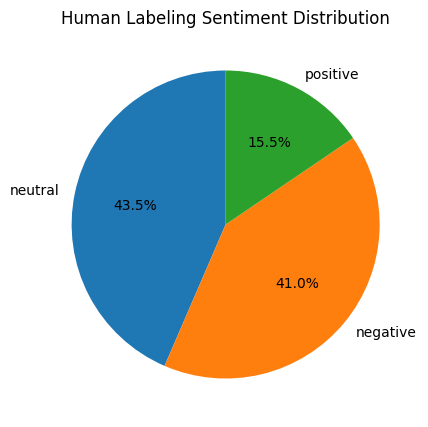

In [ ]:
print(df.human_sentiment.value_counts())

sentiment_counts = df['human_sentiment'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Human Labeling Sentiment Distribution')
plt.show()

In [ ]:
df

,index,text,processed_comment,vader_sentiment,human_sentiment
0,0,Muy buena idea😅😅 el negocio de los stickers 😂,buena idea😅😅 negocio stickers 😂,positive,positive
1,1,Tanto Dineroooo!!! Por eso la mayoría del cír...,dineroooo mayoría círculo gobierno turno enriq...,neutral,negative
2,2,Excelente exposición del tema,excelente exposición tema,neutral,positive
3,3,Quique... donde estan los delfines ?,quique estan delfines,neutral,neutral
4,4,Grand exponente. Lo mejor de Guate.,grand exponente mejor guate,positive,positive
...,...,...,...,...,...
827,827,Mucho bla bla bla del Sr Alcalde pero no concl...,bla bla bla sr alcalde concluye mmmm,neutral,negative
828,828,Entonces que va hacer con los buses y túc túc ...,entonces va hacer buses túc túc actuales si di...,neutral,neutral
829,829,"Leasing=arrendamiento, por si se le está olvid...",leasingarrendamiento si olvidando español😂,positive,neutral
830,830,El famoso leasing,famoso leasing,neutral,neutral


# BERT Topic

In [ ]:
!pip install bertopic
!pip install umap-learn
!pip install nltk
!pip install cleantext
!pip install ftfy

## Training and running the model

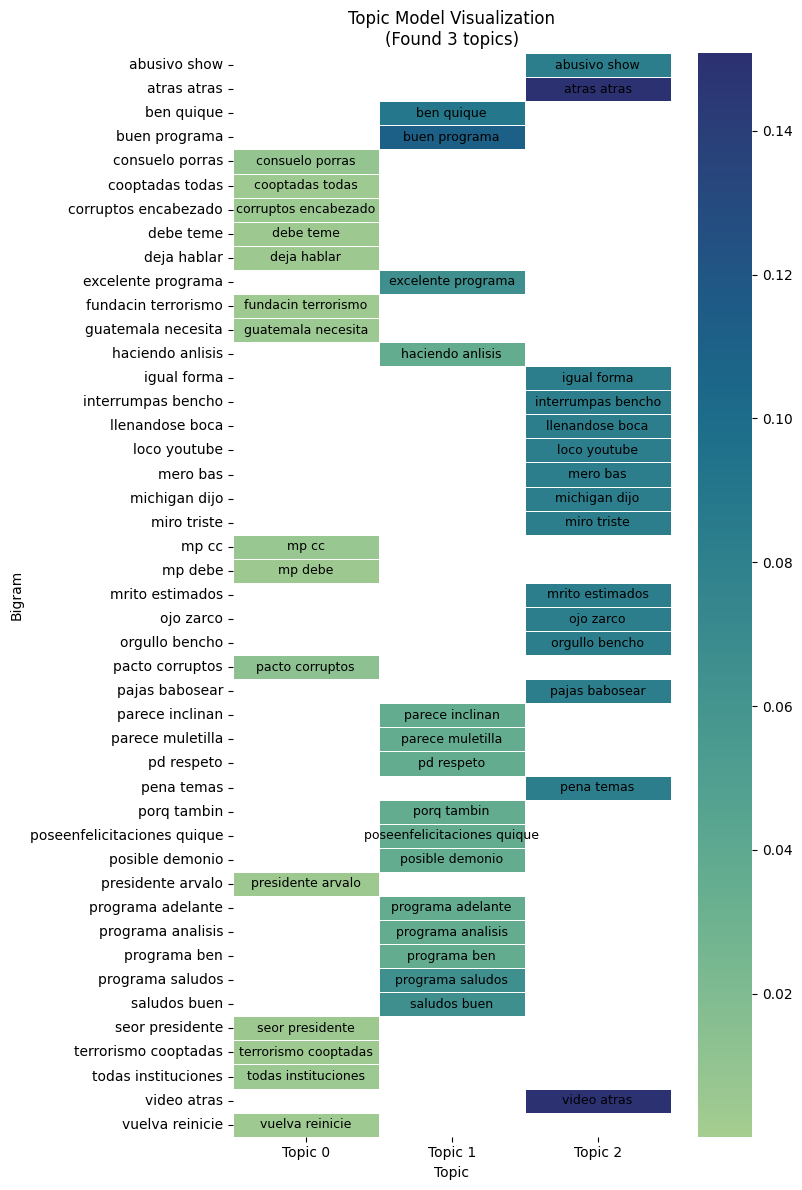

Number of topics found: 3


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Optional
from bertopic import BERTopic
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from cleantext import clean
from ftfy import fix_encoding
import logging
from sklearn.preprocessing import MinMaxScaler

class TextTopicAnalyzer:
    """A class to handle text preprocessing and topic modeling using BERTopic."""

    def __init__(self,
                 language: str = 'spanish',
                 n_topics: str = "auto",
                 top_n_words: int = 15,
                 ngram_range: Tuple[int, int] = (2, 2),
                 random_state: int = 42):
        self.language = language
        self.n_topics = n_topics
        self.top_n_words = top_n_words
        self.ngram_range = ngram_range
        self.random_state = random_state
        self.actual_n_topics = None
        self.topic_ids = None  # Store actual topic IDs
        self.setup_logging()

    def setup_logging(self):
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def clean_text(self, text: str) -> str:
        try:
            text = fix_encoding(str(text))
            text = clean(
                text,
                punct=True,
                numbers=True,
                extra_spaces=True,
                lowercase=True
            )
            return text.lower().strip()
        except Exception as e:
            self.logger.error(f"Error cleaning text: {str(e)}")
            return ""

    def prepare_stopwords(self) -> List[str]:
        standard_stopwords = list(stopwords.words(self.language))
        additional_stopwords = [
            'a', 'al', 'algunas', 'algunos', 'ambos', 'ante',
            'antes', 'aquel', 'aquella', 'aquí', 'arriba', 'así',
            'atrás', 'aun', 'aunque', 'bajo', 'bastante', 'bien',
            'cabe', 'cada', 'casi', 'cierto', 'como', 'con', 'conmigo',
            'conseguimos', 'conseguir', 'consigo', 'consigue', 'consiguen',
            'consigues', 'contigo', 'contra', 'cual', 'cuales', 'cualquier',
            'cuan', 'cuando', 'cuanto', 'de', 'dejar', 'del', 'demasiada',
            'dentro', 'desde', 'donde', 'dos', 'el', 'él', 'ella',
            'emplean', 'emplear', 'empleas', 'empleo', 'en',
            'encima', 'entonces', 'entre', 'era', 'eramos', 'eran', 'eres',
            'es','esa', 'esta', 'estaba', 'estado', 'estáis', 'estamos',
            'están', 'estar', 'este', 'estoy', 'etc', 'fin', 'fue', 'fueron',
            'fui', 'fuimos','gueno', 'ha', 'hace', 'hacemos', 'hacen',
            'hacer', 'hacia', 'hago', 'hasta','junto', 'la', 'largo', 'más','mas'
            'me', 'menos', 'mi', 'mía', 'mientras', 'mío', 'misma', 'modo',
            'mucha', 'mucho', 'muy', 'nada', 'ni', 'ningún', 'no', 'nos',
            'nosotras', 'nuestra', 'nunca', 'otra','para', 'parecer',
            'pero', 'poca', 'podemos', 'poder', 'podría',
            'podríamos', 'podrían', 'por', 'por qué', 'porque', 'primero',
            'puede', 'puedo', 'pues', 'que', 'qué', 'querer', 'quién', 'quienesquiera',
            'quienquiera', 'quizá', 'sabe', 'sabemos', 'saber',
            'se', 'según', 'ser', 'si', 'sí', 'siempre','siendo', 'sin', 'sino',
            'sobre', 'solamente', 'solo', 'sólo', 'somos', 'soy',
            'sr', 'sra', 'su', 'suya', 'tal', 'también', 'tampoco',
            'tan', 'tanta', 'te', 'tenemos', 'tener', 'tengo', 'ti',
            'tiempo', 'tiene', 'tienen', 'toda', 'tomar', 'trabaja',
            'trabajamos', 'trabajan', 'trabajar', 'trabajas', 'tras', 'tú', 'tu',
            'tus', 'tuya', 'último', 'ultimo', 'un', 'una', 'uno', 'usa',
            'usamos', 'usan', 'usar', 'uso', 'usted', 'va', 'valor',
            'vamos', 'varias', 'vaya', 'verdadera', 'voy',
            'y', 'ya', 'yo'
        ]
        return standard_stopwords + additional_stopwords

    def create_topic_model(self) -> BERTopic:
        vectorizer = CountVectorizer(
            ngram_range=self.ngram_range,
            stop_words=self.prepare_stopwords()
        )

        umap_model = UMAP(
            n_neighbors=15,
            n_components=5,
            min_dist=0.0,
            metric='cosine',
            random_state=self.random_state
        )

        model = BERTopic(
            top_n_words=self.top_n_words,
            n_gram_range=self.ngram_range,
            nr_topics=self.n_topics,
            vectorizer_model=vectorizer,
            umap_model=umap_model,
            calculate_probabilities=True
        )

        return model

    def fit_transform(self, texts: List[str]) -> Tuple[List[int], np.ndarray]:
        self.logger.info("Starting topic modeling process...")

        try:
            self.model = self.create_topic_model()
            topics, probs = self.model.fit_transform(texts)

            # Get topic frequency to identify valid topics
            topic_freq = self.model.get_topic_freq()
            self.topic_ids = topic_freq[topic_freq['Topic'] != -1]['Topic'].tolist()
            self.actual_n_topics = len(self.topic_ids)

            self.logger.info(f"Successfully identified {self.actual_n_topics} topics")
            return topics, probs

        except Exception as e:
            self.logger.error(f"Error in topic modeling: {str(e)}")
            raise

    def create_topic_dataframe(self) -> pd.DataFrame:
        if self.topic_ids is None:
            raise ValueError("Model hasn't been fit yet. Call fit_transform first.")

        topic_dfs = []

        for topic_id in self.topic_ids:
            topic_data = self.model.get_topic(topic_id)
            if topic_data:
                topic_df = pd.DataFrame(
                    topic_data,
                    columns=[f"Topic_{topic_id}_word", f"Topic_{topic_id}_prob"]
                )
                topic_dfs.append(topic_df)

        if not topic_dfs:
            raise ValueError("No valid topics found in the model")

        return pd.concat(topic_dfs, axis=1)

    def plot_topic_heatmap(self, topics_df: pd.DataFrame,
                          title: str = 'Topic Model Visualization',
                          figsize: Tuple[int, int] = (12, 12)) -> None:
        if self.topic_ids is None:
            raise ValueError("Model hasn't been fit yet. Call fit_transform first.")

        # Reshape data for visualization
        reshaped_data = pd.DataFrame(columns=['Bigram', 'Topic', 'Prob'])

        for topic_id in self.topic_ids:
            temp_df = pd.DataFrame({
                'Bigram': topics_df[f"Topic_{topic_id}_word"],
                'Topic': f'Topic {topic_id}',
                'Prob': topics_df[f"Topic_{topic_id}_prob"]
            })
            reshaped_data = pd.concat([reshaped_data, temp_df])

        if reshaped_data.empty:
            self.logger.warning("No data available for heatmap visualization")
            return

        # Create pivot table
        pivot_table = reshaped_data.set_index('Bigram').pivot(
            columns='Topic',
            values='Prob'
        ).fillna(0)

        # Adjust figure size based on data
        adjusted_figsize = (
            min(figsize[0], 2 + self.actual_n_topics * 2),
            min(figsize[1], 2 + len(pivot_table) * 0.3)
        )

        plt.figure(figsize=adjusted_figsize)
        cmap = sns.color_palette("crest", as_cmap=True)
        cmap.set_under(color='white')

        # Create heatmap
        sns.heatmap(
            pivot_table,
            cmap=cmap,
            linewidths=0.5,
            annot=False,
            cbar=True,
            mask=(pivot_table == 0),
            vmin=0.0001
        )

        # Add bigram labels
        for i, bigram in enumerate(pivot_table.index):
            for j, topic in enumerate(pivot_table.columns):
                if pivot_table.loc[bigram, topic] > 0:
                    plt.text(
                        j + 0.5,
                        i + 0.5,
                        bigram,
                        ha='center',
                        va='center',
                        color='black' if pivot_table.loc[bigram, topic] > 0 else 'white',
                        fontsize=9
                    )

        plt.title(f"{title}\n(Found {self.actual_n_topics} topics)")
        plt.xlabel('Topic')
        plt.ylabel('Bigram')
        plt.tight_layout()
        plt.show()

    def get_topic_summary(self) -> pd.DataFrame:
        if self.topic_ids is None:
            raise ValueError("Model hasn't been fit yet. Call fit_transform first.")

        summary = self.model.get_topic_info()
        return summary[summary['Topic'] != -1]

    def analyze_text(self, df: pd.DataFrame, text_column: str) -> Dict:
        self.logger.info("Starting text analysis pipeline...")

        # Preprocess texts
        cleaned_texts = df[text_column].apply(self.clean_text)

        # Fit topic model
        topics, probabilities = self.fit_transform(cleaned_texts.tolist())

        # Create topic DataFrame
        topics_df = self.create_topic_dataframe()

        # Get topic summary
        topic_summary = self.get_topic_summary()

        # Create visualization
        self.plot_topic_heatmap(topics_df)

        return {
            'topics': topics,
            'probabilities': probabilities,
            'topic_data': topics_df,
            'summary': topic_summary,
            'n_topics_found': self.actual_n_topics,
            'topic_ids': self.topic_ids
        }

# instance of Bert Topic model
analyzer = TextTopicAnalyzer(language='spanish', n_topics=4) #topics +1 given that one topic is for outliers
results = analyzer.analyze_text(df, 'text')
print(f"Number of topics found: {results['n_topics_found']}")

#New column with topics from Bertopic
df['topic'] = results['topics']

## Graph Topics

In [ ]:
df['topic'].value_counts()

,count
topic,
0,470
-1,323
1,26
2,13


In [ ]:
topic_label_counts = df.groupby(['topic', 'human_sentiment'])['human_sentiment'].count().reset_index(name='count')
topic_label_counts['percentage'] = topic_label_counts.groupby('topic')['count'].transform(lambda x: x / x.sum() * 100)

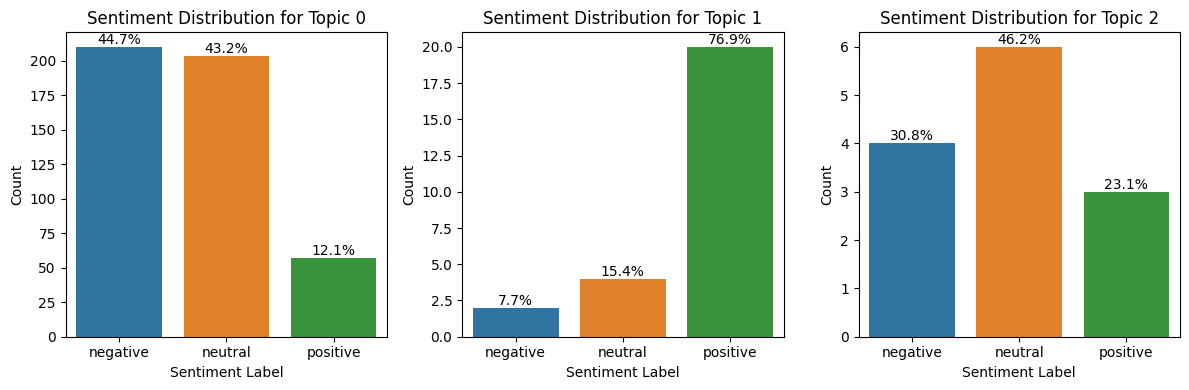

In [ ]:
# Get the number of unique topics (excluding -1)
unique_topics = topic_label_counts[topic_label_counts['topic'] != -1]['topic'].unique()
num_topics = len(unique_topics)

# Calculate the number of rows and columns for subplots
num_cols = 3  # You can adjust this
num_rows = (num_topics + num_cols - 1) // num_cols

# Create a figure and an array of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))

# Flatten the axes array
axes = axes.flatten()

# Iterate through unique topics (excluding -1) and create subplots
for i, topic in enumerate(unique_topics):
    ax = axes[i]

    sns.barplot(x='human_sentiment', y='count',
                data=topic_label_counts[topic_label_counts['topic'] == topic],
                hue='human_sentiment', dodge=False, ax=ax)

    ax.set_title(f'Sentiment Distribution for Topic {topic}')
    ax.set_xlabel('Sentiment Label')
    ax.set_ylabel('Count')

    # Add percentage labels
    for j, p in enumerate(ax.patches):
        sentiment = topic_label_counts[topic_label_counts['topic'] == topic]['human_sentiment'].iloc[j % len(topic_label_counts[topic_label_counts['topic'] == topic]['human_sentiment'].unique())]
        percentage = '{:.1f}%'.format(topic_label_counts.loc[(topic_label_counts['topic'] == topic) & (topic_label_counts['human_sentiment'] == sentiment), 'percentage'].values[0])
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), percentage, ha='center', va='bottom')

# Hide unused subplots
for j in range(num_topics, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
df

,index,text,processed_comment,vader_sentiment,human_sentiment,topic
0,0,Muy buena idea😅😅 el negocio de los stickers 😂,buena idea😅😅 negocio stickers 😂,positive,positive,0
1,1,Tanto Dineroooo!!! Por eso la mayoría del cír...,dineroooo mayoría círculo gobierno turno enriq...,neutral,negative,0
2,2,Excelente exposición del tema,excelente exposición tema,neutral,positive,0
3,3,Quique... donde estan los delfines ?,quique estan delfines,neutral,neutral,0
4,4,Grand exponente. Lo mejor de Guate.,grand exponente mejor guate,positive,positive,0
...,...,...,...,...,...,...
827,827,Mucho bla bla bla del Sr Alcalde pero no concl...,bla bla bla sr alcalde concluye mmmm,neutral,negative,0
828,828,Entonces que va hacer con los buses y túc túc ...,entonces va hacer buses túc túc actuales si di...,neutral,neutral,0
829,829,"Leasing=arrendamiento, por si se le está olvid...",leasingarrendamiento si olvidando español😂,positive,neutral,-1
830,830,El famoso leasing,famoso leasing,neutral,neutral,-1


# BERT Model

In [ ]:
# Mount Google Drive if not already mounted
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted or not in Colab environment")

source_path = "/content/drive/MyDrive/Imperial College/Capstone Project/trained_model"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Mapping sentiment to labels
label_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['human_sentiment'].map(label_dict)
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

# Split dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['processed_comment'].tolist(),
    df['label'].tolist(),
    test_size=0.20,
    stratify=df['label'],  # Ensure balanced split
    random_state=42)

In [ ]:
len(train_texts), len(test_texts), len(train_labels), len(test_labels)

(665, 167, 665, 167)

## Tokenizing texts

In [ ]:
from transformers import BertTokenizer

# Load pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
  )
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
  )

In [ ]:
import torch

# Convert to PyTorch datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

## Training the model

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

def _init_weights(module):
  if isinstance(module, torch.nn.Linear):
    module.weight.data.normal_(mean=0.0, std=0.02)
    if module.bias is not None:
      module.bias.data.zero_()

# Load pre-trained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.classifier.apply(_init_weights)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
!pip install wandb
import wandb
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
#wandb Login
!wandb login
# Initialize wandb
wandb.init(project="youtube-sentiment-analysis")

wandb: Currently logged in as: javihm77 (javihm77-3pillar-global). Use `wandb login --relogin` to force relogin


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: javihm77 (javihm77-3pillar-global). Use `wandb login --relogin` to force relogin


In [ ]:
%%time

# Calculate steps
num_training_steps = len(train_dataset) * 4  # 4 epochs
num_warmup_steps = num_training_steps // 10

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,  # Increase the number of epochs
    per_device_train_batch_size=17,
    per_device_eval_batch_size=32,
    warmup_steps=num_warmup_steps,
    weight_decay=0.01,
    logging_dir='./logs',
    learning_rate=2e-5,
    fp16=True,  # Enable mixed precision training
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="wandb"
)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  report = classification_report(labels, preds, output_dict=True)
  return {
    'accuracy': acc,
    'f1_macro': report['macro avg']['f1-score'],
    'precision': report['macro avg']['precision'],
    'recall': report['macro avg']['recall']
  }

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(source_path)
tokenizer.save_pretrained(source_path)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall
1,No log,1.030533,0.455090,0.319408,0.304763,0.355426
2,No log,0.997164,0.467066,0.322800,0.313784,0.374631
3,1.035700,0.984520,0.467066,0.333333,0.311590,0.366237
4,1.035700,0.967341,0.491018,0.348434,0.335355,0.384166
5,0.896700,0.995456,0.502994,0.408415,0.585930,0.427127
6,0.896700,0.990415,0.520958,0.470598,0.516667,0.464441
7,0.896700,1.032397,0.550898,0.512515,0.559692,0.504117
8,0.580200,1.127136,0.532934,0.533837,0.526641,0.543302
9,0.580200,1.142492,0.586826,0.574668,0.626389,0.553395
10,0.291600,1.342195,0.538922,0.536544,0.547930,0.529680


CPU times: user 2min 7s, sys: 44.3 s, total: 2min 52s
Wall time: 5min 28s


('/content/drive/MyDrive/Imperial College/Capstone Project/trained_model/tokenizer_config.json',
 '/content/drive/MyDrive/Imperial College/Capstone Project/trained_model/special_tokens_map.json',
 '/content/drive/MyDrive/Imperial College/Capstone Project/trained_model/vocab.txt',
 '/content/drive/MyDrive/Imperial College/Capstone Project/trained_model/added_tokens.json')

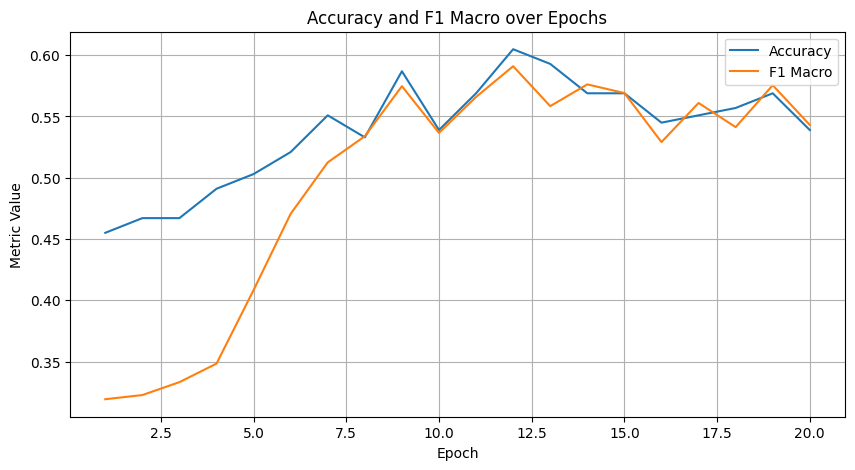

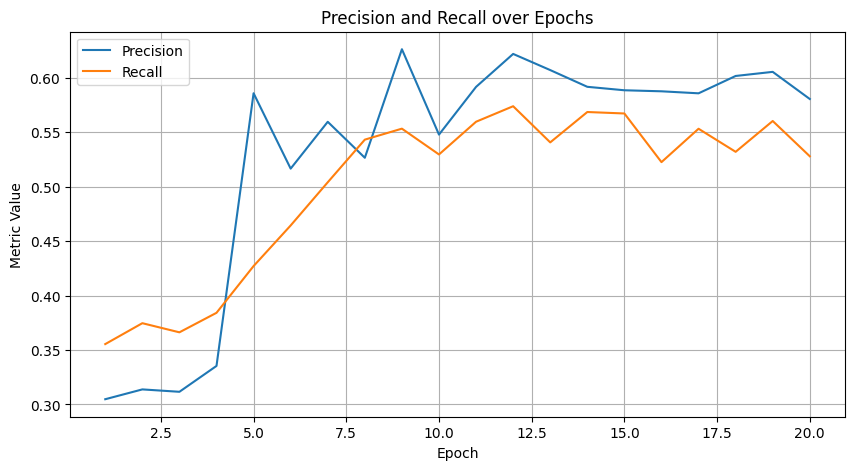

In [ ]:
# After training:
# Access the evaluation results
metrics = trainer.state.log_history

# Extract accuracy and f1_macro
accuracy = [entry['eval_accuracy'] for entry in metrics if 'eval_accuracy' in entry]
f1_macro = [entry['eval_f1_macro'] for entry in metrics if 'eval_f1_macro' in entry]

# Create the plot for accuracy and f1_macro
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy) + 1), accuracy, label='Accuracy')
plt.plot(range(1, len(f1_macro) + 1), f1_macro, label='F1 Macro')
plt.title('Accuracy and F1 Macro over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Extract precision and recall
precision = [entry['eval_precision'] for entry in metrics if 'eval_precision' in entry]
recall = [entry['eval_recall'] for entry in metrics if 'eval_recall' in entry]

# Create the plot for precision and recall
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(precision) + 1), precision, label='Precision')
plt.plot(range(1, len(recall) + 1), recall, label='Recall')
plt.title('Precision and Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

## Evaluating the model

In [ ]:
# Mount Google Drive if not already mounted
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive already mounted or not in Colab environment")

source_path = "/content/drive/MyDrive/Imperial College/Capstone Project/trained_model/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score, classification_report
import torch
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the trained model and tokenizer
model = BertForSequenceClassification.from_pretrained(source_path)
tokenizer = BertTokenizer.from_pretrained(source_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

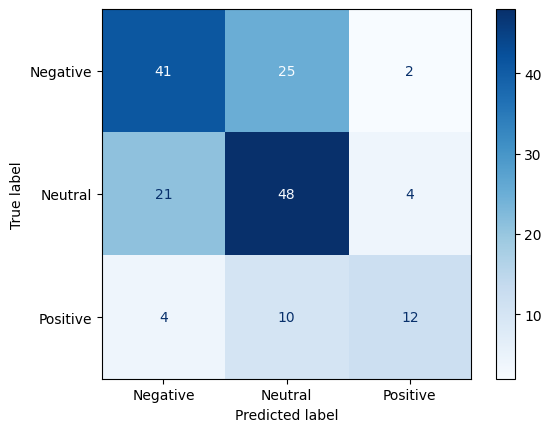

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61        68
           1       0.58      0.66      0.62        73
           2       0.67      0.46      0.55        26

    accuracy                           0.60       167
   macro avg       0.62      0.57      0.59       167
weighted avg       0.61      0.60      0.60       167



In [ ]:
# Get predictions for the test dataset
preds = []
labels = []

# Prepare the test dataset
inputs = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt").to(device)

with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits
  probabilities = torch.softmax(logits, dim=-1)  # Get probabilities
  predictions = torch.argmax(logits, dim=-1)
  confidences = torch.max(probabilities, dim=-1).values  # Get confidence
  preds.extend(predictions.cpu().numpy())
  labels.extend(test_labels)

# Generate confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

report = classification_report(labels, preds)
print('Classification Report:')
print(report)

In [ ]:
misclassifications = []

for i in range(len(test_texts)):
  if preds[i] != labels[i]:
    indices = df[df['processed_comment'] == test_texts[i]].index.tolist()
    if indices:  # Check if indices is not empty
        index = indices[0]  # Use the first index if there are matches
    else:
        index = None  # Handle the case where there are no matches

    misclassifications.append({
      "index": index,
      "text": test_texts[i],
      "true_label": labels[i],
      "predicted_label": preds[i].item(),  # Convert to Python scalar
      "confidence": confidences[i].item()  # Convert to Python scalar
    })

df_misclassifications = pd.DataFrame(misclassifications)

In [ ]:
# Display some statistics about misclassifications
print("\nMisclassification Analysis:")
print(f"Total misclassified examples: {len(df_misclassifications)} of {len(df)} that represents {len(df_misclassifications)/len(df) * 100:.2f}%")

# Save misclassification analysis
df_misclassifications = df_misclassifications.sort_values(by='index', ascending=True)
df_misclassifications.to_csv('/content/drive/MyDrive/Imperial College/Capstone Project/misclassified_analysis.csv', index=False)
print("\nMisclassification analysis saved to 'misclassified_analysis.csv'")


Misclassification Analysis:
Total misclassified examples: 66 of 832 that represents 7.93%

Misclassification analysis saved to 'misclassified_analysis.csv'


In [ ]:
df_misclassifications.head(5)

,index,text,true_label,predicted_label,confidence
50,4,grand exponente mejor guate,2,1,0.932181
18,7,señor barrientos tuiter😅,2,0,0.967448
6,8,excelentes análisis formativos actualizados en...,2,1,0.982351
24,11,curruchiche méxico impugnar elecciones quiere ...,0,1,0.918656
5,71,entonces siero mal asesorado tomando notas gen...,0,1,0.988353


# Predictions

In [ ]:
def predict_sentiment(text):
    """Predicts the sentiment of a given text using a trained BERT model.

    Args:
        text (str): The text to predict the sentiment of.

    Returns:
        tuple: A tuple containing the predicted sentiment and the probabilities for each sentiment class.
    """

    # Tokenize the text
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")

    # Move the tensors to the device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=1)  # Calculate probabilities
        predicted_class = torch.argmax(probabilities, dim=1)

    # Map predicted class to sentiment label
    label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    predicted_sentiment = label_mapping[predicted_class.item()]

    # Convert probabilities to a dictionary
    probabilities_dict = {
        'negative': probabilities[0][0].item(),
        'neutral': probabilities[0][1].item(),
        'positive': probabilities[0][2].item()
    }

    return predicted_sentiment, probabilities_dict

In [ ]:
predict_texts = [("Consuelo Porras fiscal del MP es una vieja corrupta, no hay que darle más dinero porque persigue a gente inocente")
  ,("Muy buen programa Quique y Bencho! buen análisis del acontecer nacional, saludos desde Pinula!")]

for text in predict_texts:
    sentiment, probabilities = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Probabilities: {probabilities}\n")

Text: Consuelo Porras fiscal del MP es una vieja corrupta, no hay que darle más dinero porque persigue a gente inocente
Predicted Sentiment: negative
Probabilities: {'negative': 0.994055986404419, 'neutral': 0.003801680402830243, 'positive': 0.0021423818543553352}

Text: Muy buen programa Quique y Bencho! buen análisis del acontecer nacional, saludos desde Pinula!
Predicted Sentiment: positive
Probabilities: {'negative': 0.0062137264758348465, 'neutral': 0.0030697023030370474, 'positive': 0.9907165169715881}



In [ ]:
# Close wandb run
wandb.finish()

eval/accuracy,▁▂▂▃▃▄▅▅▇▅▆█▇▆▆▅▅▆▆▅
eval/f1_macro,▁▁▁▂▃▅▆▇█▇▇█▇█▇▆▇▇█▇
eval/loss,▁▁▁▁▁▁▁▂▂▃▄▄▅▆▇█▇█▇▇
eval/precision,▁▁▁▂▇▆▇▆█▆▇██▇▇▇▇▇█▇
eval/recall,▁▂▁▂▃▄▆▇▇▇██▇██▆▇▇█▇
eval/runtime,█▄▄▅▃▄▁▃▄▂▄▄▄▄▂▃▃▃▄▆
eval/samples_per_second,▁▅▅▄▆▅█▅▅▆▅▅▄▅▇▅▅▅▅▃
eval/steps_per_second,▁▅▅▄▆▅█▅▅▆▅▅▄▅▇▅▅▅▅▃
train/epoch,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇████
train/global_step,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇████
train/grad_norm,▂▇██▁▁▁▁


# SHAP Test

In [ ]:
import shap

def predict_fn(texts):
  """Wraps the BERT model for SHAP compatibility."""
  texts = [str(text) for text in texts]  # Convert to strings
  inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)  # Move input to device
  with torch.no_grad():
      outputs = model(**inputs)
  probabilities = torch.softmax(outputs.logits, dim=-1)
  return probabilities.cpu().numpy()  # Return probabilities on CPU

In [ ]:
explainer = shap.Explainer(predict_fn, tokenizer)
shap_values = explainer(predict_texts)

In [ ]:
shap.plots.text(shap_values)  # Visualize all predictions

Consuelo Porras fiscal del MP es una vieja corrupta, no hay que darle más dinero porque persigue a gente inocente


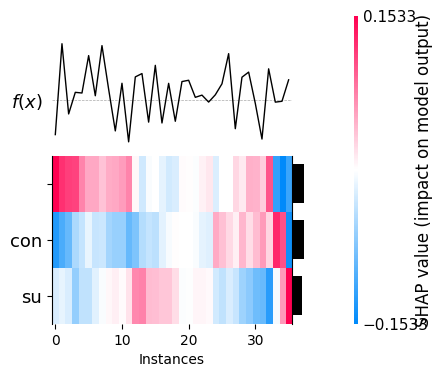

<Axes: xlabel='Instances'>

In [ ]:
print(predict_texts[0])
shap.plots.heatmap(shap_values[0])

Muy buen programa Quique y Bencho! buen análisis del acontecer nacional, saludos desde Pinula!


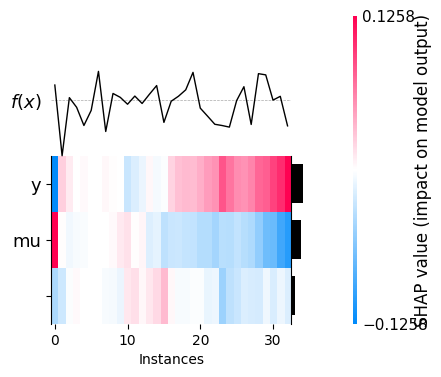

<Axes: xlabel='Instances'>

In [ ]:
print(predict_texts[1])
shap.plots.heatmap(shap_values[1])